PSI3532 - Filtragem Adaptativa e Aplicações
# Experiência 4 - Rastreamento
Henrique Souza de Melo - 9347031

In [1]:
import numpy as np
from numpy import pi, sqrt, sin, trace, log10, arange
from numpy.random import randn
from numpy.linalg import inv

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size':14})

from scipy import signal

from filters import LMS #filtro LMS previamente desenvolvido

## Gerando as entradas e o filtro $H(z)$

In [2]:
def experiencia_4_inputs(item='1', total_time=400, H_0=[1, .5], M=2):
    assert(len(H_0) == M)
    params = {
        '1' : {
            'a' : 0,
            'model' : 'a'
        },
        '2' : {
            'a' : .9,
            'model' : 'a'
        },
        '3a' : {
            'a' : 0,
            'model' : 'b',
            'w0' : 1e-3 * pi
        },
        '3b' : {
            'a' : 0,
            'model' : 'b',
            'w0' : .2 * pi
        }
    }
    a = params[item]['a']
    model = params[item]['model']
    if (model == 'b'):
        w0 = params[item]['w0']
    
    n = arange(total_time)
    u = randn(len(n))
    x = signal.lfilter(b=[sqrt(1 - a ** 2)], a=[1, -a], x=u)
    y = np.zeros(total_time)
    sigma_v = sqrt(.01)
    v = randn(len(n)) * sigma_v
    H = np.array([H_0])
    
    if(model == 'a'):
        sigma_q = sqrt(1e-4)
        for i in range(1, len(n)):    
            q = randn(H.shape[1]) * sigma_q
            H = np.concatenate((H, [H[-1] + q]))
            
    if(model == 'b'):
        w0 = params[item]['w0']
        H = np.ones((len(n), M))
        for i in n:
            H[i] *= sin(i * w0)
    
    for i in range(M - 1, len(y)):
        for j in range(M):
            y[i] += x[i - j] * H[i, j]
    d = y + v
    
    return n, x, d, H
    

## Cálculo das métricas de desempenho

In [3]:
def experiencia_4_metrics(total_time, N, mu=.08, item='1'):
    sigma_u = sqrt(1)
    sigma_o = sqrt(.01)
    sigma_q = sqrt(1e-4)

    M = 2
    
    EMSE = np.zeros(total_time)
    MSD = np.zeros(total_time)
    
    if((item != '3a') and (item != '3b')):
        if(item == '1'):
            a = 0
        elif(item == '2'):
            a = .9
        #calculo da autocorrelacao de x
        r_x = lambda l : a ** abs(l) * sigma_u ** 2

        #calculo de R_phi
        R_phi = np.zeros((M, M))
        for i in range(len(R_phi)):
            for j in range(len(R_phi)):
                R_phi[i, j] = r_x(abs(i-j))

        MSD_teorico = np.ones(total_time) * (
            (mu * sigma_o ** 2 * M) / 2) + (
            (sigma_q ** 2 * trace(inv(R_phi))) / (2 * mu)
                                           )
        EMSE_teorico = np.ones(total_time) * (
            (mu * sigma_o ** 2 * trace(R_phi)) / 2) + (
            (sigma_q ** 2 * M) / (2 * mu))
        
    
    #repetir o experimento N vezes
    for i in range(N):
        n, x, d, H = experiencia_4_inputs(item=item, total_time=total_time, M=M)
        
        # nesse caso especifico
        W_o = H
        
        lms_filter = LMS(M=M, mu=mu)

        for k in range(0, len(x)):
            lms_filter.buffer(x[k], d[k])
        
        EMSE += (1 / N) * (np.square(lms_filter.e) - sigma_o ** 2)
        
        deltaW = W_o - lms_filter.W
        
        MSD += (1 / N) * np.sum(np.square(deltaW), axis=1)
        
        
    if((item != '3a') and (item != '3b')):
        return MSD, MSD_teorico, EMSE, EMSE_teorico
    else:
        return MSD, EMSE, lms_filter, H
    

## Valor ótimo de passo

In [4]:
def experiencia_4_mu(item):
    if(item == '1'):
        a = 0
    elif(item == '2'):
        a = .9
    else:
        return .01
    
    sigma_u = sqrt(1)
    sigma_v = sqrt(.01)
    sigma_q = sqrt(1e-4)
    
    M = 2
    
    #calculo da autocorrelacao de x
    r_x = lambda l : a ** abs(l) * sigma_u ** 2

    #calculo de R_phi
    R_phi = np.zeros((M, M))
    for i in range(len(R_phi)):
        for j in range(len(R_phi)):
            R_phi[i, j] = r_x(abs(i-j))

    mu_otimo = sqrt((M * sigma_q ** 2) / (sigma_v ** 2 * trace(R_phi)))
    
    return mu_otimo

In [34]:
experiencia_4_mu(item='1')

0.09999999999999999

In [35]:
experiencia_4_mu(item='2')

0.09999999999999999

In [37]:
experiencia_4_mu(item='3a')

0.01

In [38]:
experiencia_4_mu(item='3b')

0.01

## Traçando em função de $\mu$ e curva do $\mu_{otimo}$

In [41]:
def experiencia_4_plots(item='1', total_time=500, N=100, avg_start_point=200, mu_stop=3):
    mu_otimo = experiencia_4_mu(item)
    mu_range = arange(start=.01*mu_otimo, stop=mu_stop*mu_otimo, step=.01)

    MSD = np.array([])
    EMSE = np.array([])
    
    if((item != '3a') and (item != '3b')):
        MSD_teorico = np.array([])
        EMSE_teorico = np.array([])

    for mu in mu_range:
        if((item != '3a') and (item != '3b')):
            MSD_i, MSD_teorico_i, EMSE_i, EMSE_teorico_i = experiencia_4_metrics(
                total_time=total_time,
                N=N,
                mu=mu,
                item=item
            )
            MSD_teorico = np.append(
                MSD_teorico,
                MSD_teorico_i[150:total_time].mean()
            )
            EMSE_teorico = np.append(
                EMSE_teorico,
                EMSE_teorico_i[150:total_time].mean()
            )
        else:
            MSD_i, EMSE_i, lms_filter_i, H_i = experiencia_4_metrics(
                total_time=total_time,
                N=N,
                mu=mu,
                item=item
            )
        MSD = np.append(MSD, MSD_i[150:total_time].mean())
        EMSE = np.append(EMSE, EMSE_i[150:total_time].mean())
        
    rcParams.update({'font.size':14})
    fig = plt.figure(figsize=(15,15))
    if((item != '3a') and (item != '3b')):
        ax0 = fig.add_subplot(211)
    else:
        ax0 = fig.add_subplot(311)
    ax0.semilogy(mu_range, MSD)
    ax0.semilogy(mu_range, EMSE)
    if((item != '3a') and (item != '3b')):
        ax0.semilogy(mu_range, MSD_teorico, '--C0')
        ax0.semilogy(mu_range, EMSE_teorico, '--C1')
        ax0.legend(['MSD', 'EMSE', 'MSD teórico', 'EMSE teórico'])
    else:
        ax0.legend(['MSD', 'EMSE'])
    ax0.title.set_text(
        'Métricas de desempenho em função do passo $\mu$'
    )
    fig.text(0, 1.08,
         '$N=${N}\n$nmax$={total_time}'.format(N=N,total_time=total_time),
         verticalalignment='center',
         transform=ax0.transAxes)
    plt.xlabel('$\mu$')

    if((item != '3a') and (item != '3b')):
        ax1 = fig.add_subplot(212)
        MSD_o, MSD_teorico_o, EMSE_o, EMSE_teorico_o = experiencia_4_metrics(
            total_time=total_time,
            N=N,
            mu=mu_otimo,
            item=item
        )
        ax1.semilogy(MSD_o, 'C0')
        ax1.semilogy(MSD_teorico_o, '--C2')
        ax1.semilogy(EMSE_o, 'C1')
        ax1.semilogy(EMSE_teorico_o, '--C3')
        ax1.legend(['MSD', 'MSD teórico', 'EMSE', 'EMSE teórico'])
        
    else:
        ax1 = fig.add_subplot(312)
        MSD_o, EMSE_o, lms_filter_o, H_o = experiencia_4_metrics(
            total_time=total_time,
            N=N,
            mu=mu_otimo,
            item=item
        )
        ax1.semilogy(MSD_o, 'C0')
        ax1.semilogy(EMSE_o, 'C1')
        ax1.legend(['MSD', 'EMSE'])
    
    ax1.title.set_text(
'Métricas de desempenho durante adaptação do filtro com o passo ótimo $\mu={mu_otimo}$'.format(
            mu_otimo=mu_otimo
        )
    )
    plt.xlabel('$n$')
    
    if((item=='3a') or (item=='3b')):
        ax3 = fig.add_subplot(313)
        plt.plot(lms_filter_o.W[:,0])
        plt.plot(H_o[:,0])
        plt.legend(['$w_0$', '$h_0$'])
        ax3.title.set_text('Rastreamento do coeficiente no tempo')
        plt.xlabel('$n$')


### Exercício 1

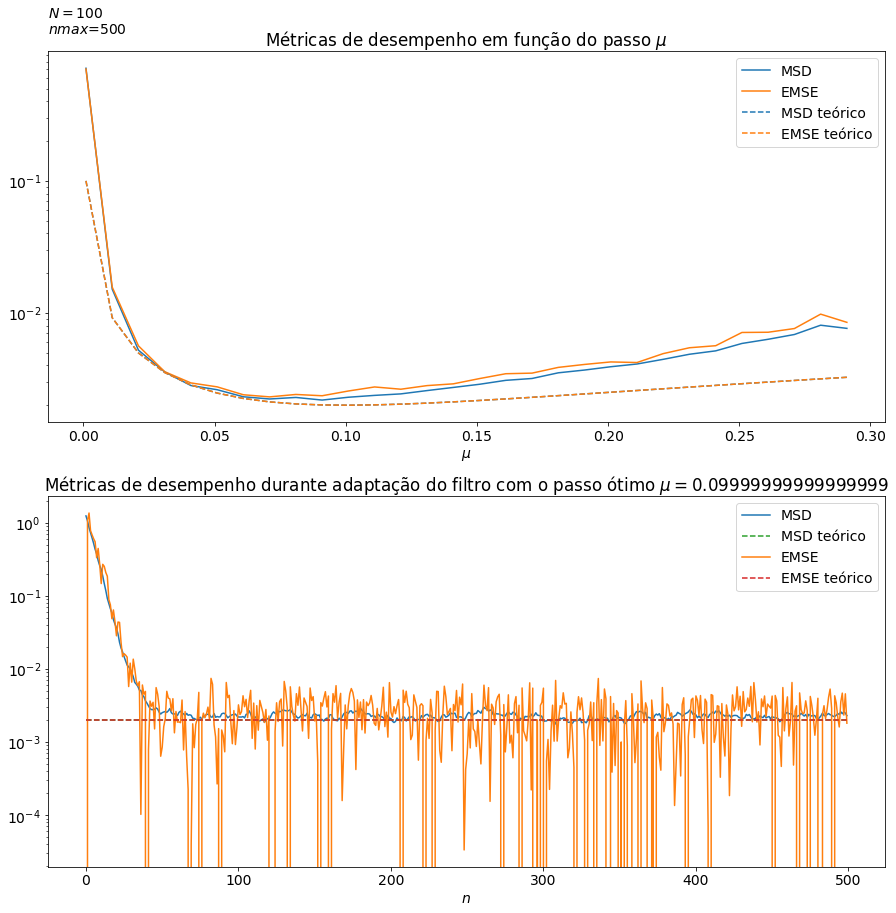

In [42]:
experiencia_4_plots(item='1')

### Exercício 2

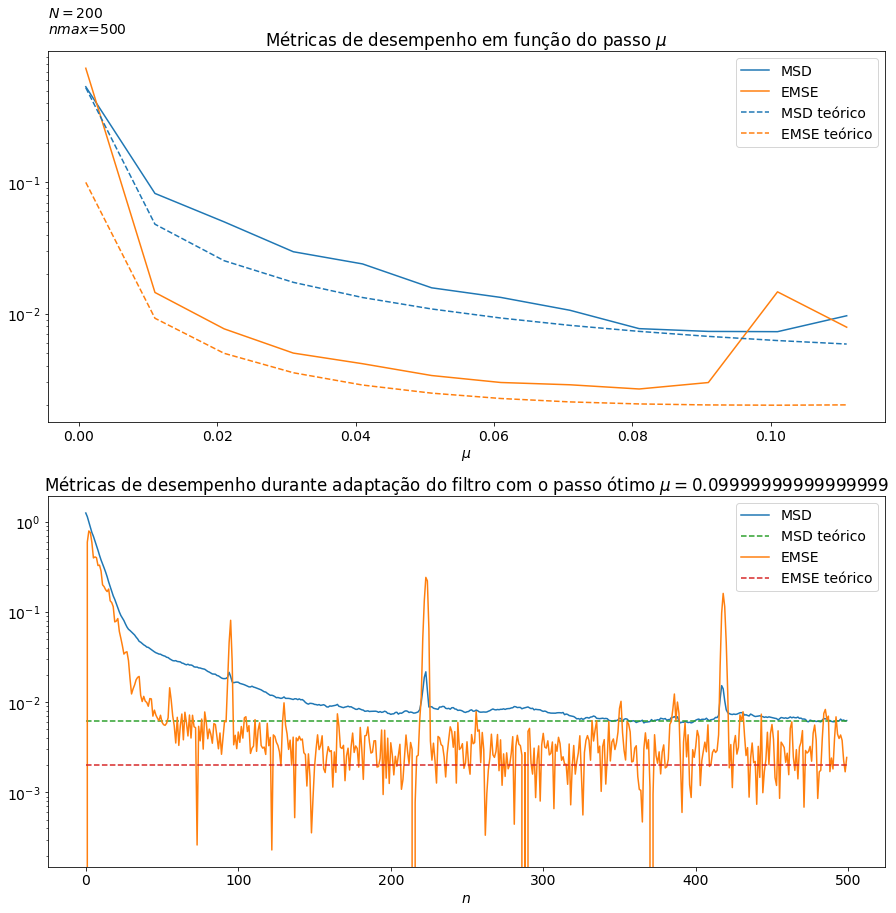

In [43]:
experiencia_4_plots(N=200, item='2', mu_stop=1.15)

### Exercício 3a

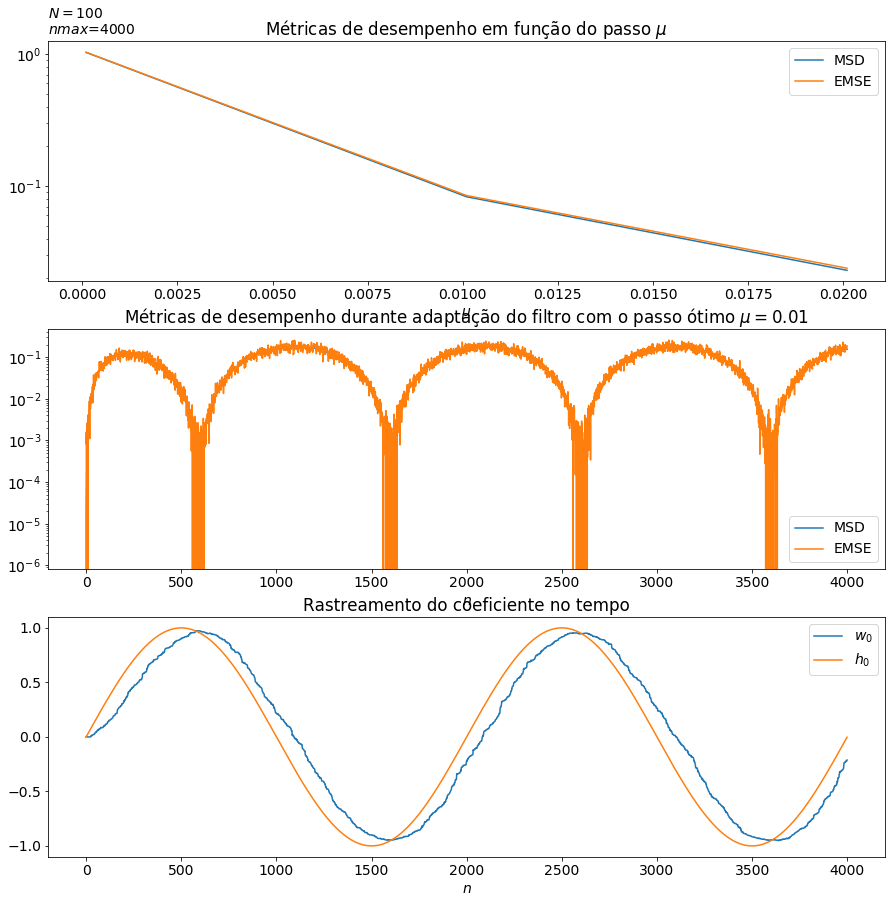

In [32]:
experiencia_4_plots(item='3a', total_time=4000)

### Exercício 3b

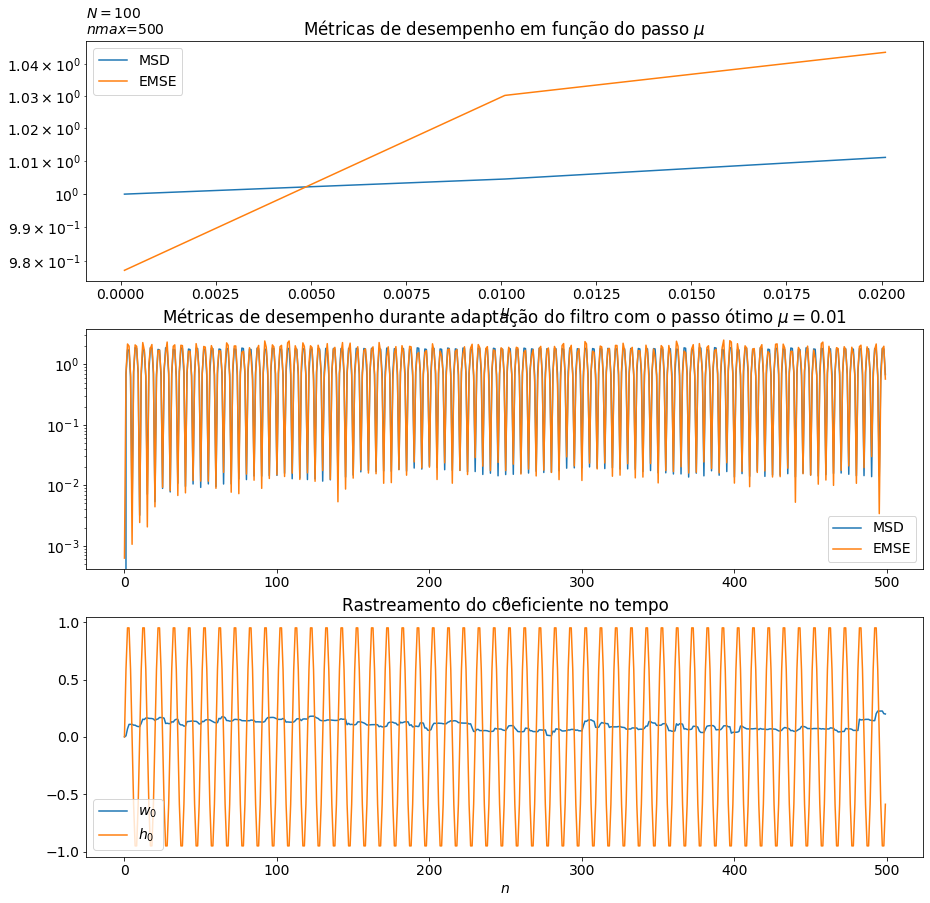

In [33]:
experiencia_4_plots(item='3b')